# Monitoring and Analysis of Wildfire and Vegetation Loss

This project used Google Earth Engine and Python geospatial tools to assess fire activity, vegetation condition, and post-fire severity.

The code is organized as follows:
- Daily Fire Monitoring
  - Data source: VNP14IMGTDL_NRT (VIIRS 375m Active Fire Product)
  - Visualize daily active fire detections using geemap and xarray
- NDVI (Normalized Difference Vegetation Index) Analysis
  - Compute NDVI before and after the fire event using Sentinel-2 imagery
  - Visualize spatial changes in vegetation health
- Vegetation Loss Estimation
  - Apply image segmentation to assess NDVI changes across burned regions
  - Use Otsu thresholding to classify and quantify vegetation loss
- NBR (Normalized Burn Ratio) and Burn Severity
  - Compute pre- and post-fire NBR and derive differenced NBR (dNBR)
  - Visualize burn severity map and percentage breakdown

In [ ]:
# Authenticate and Initialize Earth Engine
import ee
ee.Authenticate()
ee.Initialize(
    project='wildfire-forest', 
    opt_url='https://earthengine-highvolume.googleapis.com')

# Interactive geospatial analysis and visualization with GEE
import geemap
 
import seaborn as sns 
from skimage import measure, morphology
import geopandas as gpd
from shapely.geometry import shape

# Data handling and utilities
import numpy as np
import xarray as xr
from skimage.filters import threshold_otsu

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import contextily as cx
import rioxarray as rio
%matplotlib inline

## Detect time and location of fire events

### Create interactive map 

In [25]:
# Create interactive map with satellite base layer
Map = geemap.Map(center=[34.2, -118.35], zoom=10, basemap='ROADMAP')
# Add draw control to the map
Map.add_draw_control()

# Display the map
Map


Map(center=[34.2, -118.35], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [28]:
roi = Map.draw_last_feature.geometry()

### Import VIIRS dataset

In [29]:
time_start = ee.Date('2025-01-06')
time_end = ee.Date('2025-01-16')

firms_ic = ee.ImageCollection("NASA/LANCE/SNPP_VIIRS/C2") \
    .filterBounds(roi) \
    .filterDate(time_start, time_end)

# Mosaic to combine all fire images into one
# firms_mosaic = firms_ic.mosaic().clip(roi)

# Visualize brightness values
Map.addLayer(firms_ic, {
    'min': 300,
    'max': 400,
    'bands': ['Bright_ti4'], 
    'palette': ['yellow', 'orange', 'red', 'darkred']
}, 'FIRMS Fires')

Map.centerObject(roi, 10)



### Daily Fire Brightness Maps from VIIRS

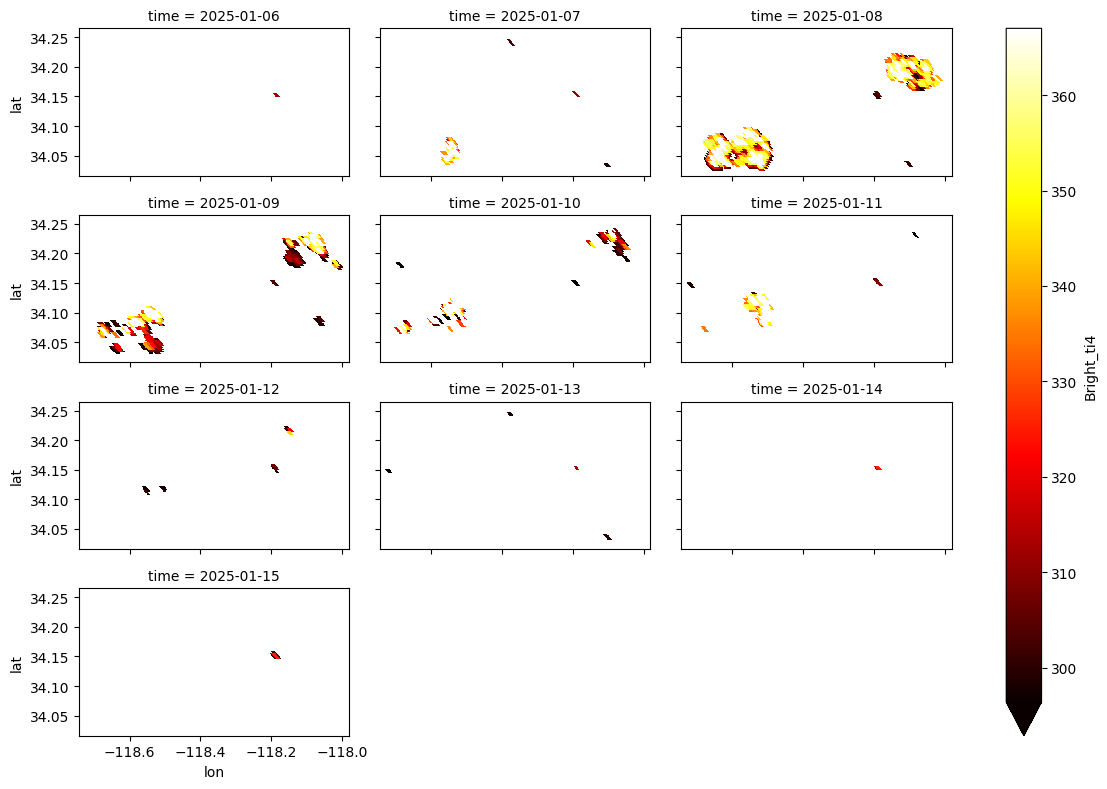

In [30]:
ds_fire = geemap.ee_to_xarray(firms_ic, geometry=roi, crs='EPSG:4326', scale=0.001) 

ds_fire.Bright_ti4.plot(
    x='lon', y='lat',
    col='time', col_wrap=3,
    cmap='hot',
    robust=True,
    figsize=(12, 8)
)

plt.show()


## Forest loss during the fire events

### Calculate NDVI before and NDVI after

Assess forest loss by NDVI (Normalized Diffference Vegetation Index), NDVI = (NIR - Red) / (NIR + Red)

In [45]:
s2 = ee.ImageCollection("COPERNICUS/S2_SR")\
    .filterDate('2024-12-20', '2025-02-28')\
    .filterBounds(roi)\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) 

def ndvi(image):
    ndvi_img = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
    return ndvi_img.copyProperties(image, ['system:time_start'])

s2_ndvi = s2.map(ndvi)


ndvi_before = s2_ndvi.filterDate('2024-12-20','2025-1-05').median().rename('ndvi_before')
ndvi_after = s2_ndvi.filterDate('2025-01-20', '2025-02-28').median().rename('ndvi_after')
ndvi_change = ndvi_before.subtract(ndvi_after).rename('ndvi_change')
ndvi_stack = ee.Image.cat(ndvi_before, ndvi_after, ndvi_change)


ds_ndvi = geemap.ee_to_xarray(ndvi_stack, geometry= roi, crs = 'EPSG:4326', scale=0.001)

segmentation = ee.Algorithms.Image.Segmentation.SNIC(ndvi_stack).select('.*mean')
ds_segmentation = geemap.ee_to_xarray(segmentation, geometry= roi, crs = 'EPSG:4326', scale=0.001)



### Visualization of NDVI Change

Check the data availability 

In [35]:
Map = geemap.Map()
Map.addLayer(ndvi_before, {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'NDVI Before')
Map.addLayer(ndvi_after, {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'NDVI After')
Map.addLayer(roi, {}, 'ROI')

Map.setCenter(-118.35, 34.2, zoom=10)
Map

Map(center=[34.2, -118.35], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

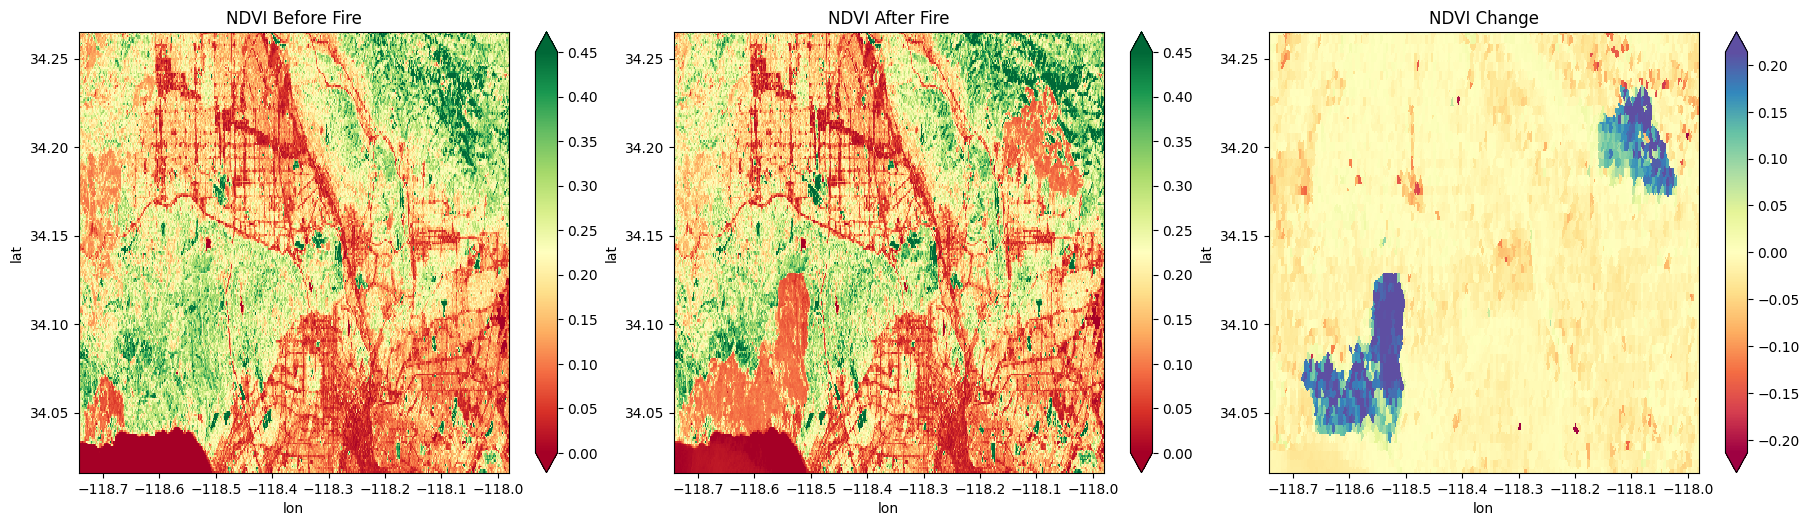

In [59]:
vmin, vmax = 0, 0.45
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
plt.tight_layout()

im0 = ds_ndvi.ndvi_before.plot(ax=ax[0], x='lon', y='lat', cmap='RdYlGn', vmin=vmin, vmax=vmax)
im0.colorbar.set_label('')
ax[0].set_title('NDVI Before Fire')

im1 = ds_ndvi.ndvi_after.plot(ax=ax[1], x='lon', y='lat', cmap='RdYlGn', vmin=vmin, vmax=vmax)
im1.colorbar.set_label('')
ax[1].set_title('NDVI After Fire')

im2 = ds_segmentation.ndvi_change_mean.plot(ax=ax[2], x = 'lon', y = 'lat', cmap = 'Spectral', robust = True)
im2.colorbar.set_label('')
ax[2].set_title('NDVI Change')

plt.show()

### Calculate the forest lost area

Otsu’s method is applied to find the threshold value about NDVI change

In [41]:
ndvi_change_values = ds_segmentation['ndvi_change_mean'].values.flatten()  # or the exact variable name
ndvi_change_values = ndvi_change_values[~np.isnan(ndvi_change_values)] 
# Assume ndvi_change_values is your 1D array without NaNs
threshold = threshold_otsu(ndvi_change_values)
print("Otsu's threshold:", threshold)

Otsu's threshold: 0.08547756


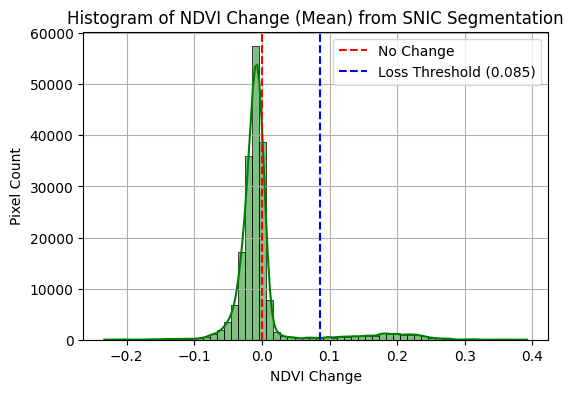

In [42]:
ndvi_change_values = ds_segmentation['ndvi_change_mean'].values.flatten()  
ndvi_change_values = ndvi_change_values[~np.isnan(ndvi_change_values)] 

plt.figure(figsize=(6, 4))
sns.histplot(ndvi_change_values, bins=60, kde=True, color='green')
plt.axvline(0, color='red', linestyle='--', label='No Change')
plt.axvline(threshold, color='blue', linestyle='--', label='Loss Threshold (0.085)')
plt.title('Histogram of NDVI Change (Mean) from SNIC Segmentation')
plt.xlabel('NDVI Change')
plt.ylabel('Pixel Count')
plt.legend()
plt.grid(True)
plt.show()

In [43]:

def burned_area(img):
  img_thr = img.gt(0.08547756).selfMask() # Keeps only pixels where NDVI change is greater than the threshold
  thr_pix = img_thr.multiply(ee.Image.pixelArea().divide(1e6)) # converts pixel count into area in square kilometers
  return thr_pix

forest_lost = burned_area(segmentation.select('ndvi_change_mean'))
forest_lost.reduceRegion(reducer = ee.Reducer.sum(), geometry = roi, scale = 30).values().get(0)


## Fire severity assessment

### Calculate dNBR

Assess fire severity by NBR (Normalized Burn Ratio), NBR = (NIR - SWIR2) / (NIR + SWIR2)

In [44]:
def nbr(img):
    nbr = img.normalizedDifference(['B8', 'B12']).rename('nbr')
    return nbr.copyProperties(img, ['system:time_start'])

s2_nbr = s2.map(nbr)

nbr_before = s2_nbr.filterDate('2024-12-20', '2025-01-05').median().rename('nbr_before')
nbr_after = s2_nbr.filterDate('2025-01-20', '2025-02-28').median().rename('nbr_after')
dnbr = nbr_before.subtract(nbr_after).rename('dnbr')
nbr_stack = ee.Image.cat(nbr_before, nbr_after, dnbr)


ds_nbr = geemap.ee_to_xarray(nbr_stack, geometry= roi, crs = 'EPSG:4326', scale=0.001)


### Burn Severity Classification from dNBR

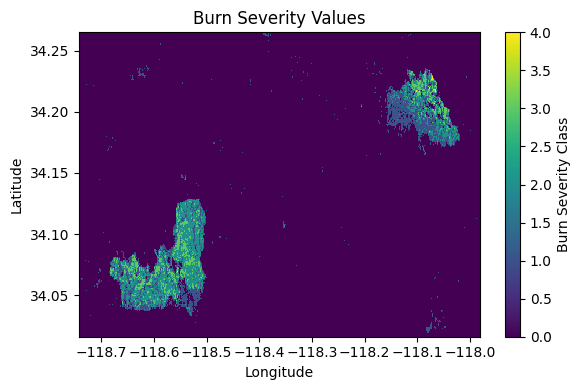

In [47]:

def classify_dnbr(dnbr_img):
    # 0 = unburned, 1 = low, 2 = moderate-low, 3 = moderate-high, 4 = high
    return (dnbr_img
        .gt(0.1).add(dnbr_img.gt(0.27)).add(dnbr_img.gt(0.44)).add(dnbr_img.gt(0.66))
        .rename('severity'))

severity = classify_dnbr(dnbr)
ds_severity = geemap.ee_to_xarray(severity, geometry=roi, crs='EPSG:4326', scale=0.001)

# da = ds_severity.to_array().squeeze()

fig, ax = plt.subplots(figsize=(6, 4))

ds_severity['severity'].plot(
    ax=ax,
    cmap='viridis',
    x='lon',  
    y='lat', 
    cbar_kwargs={'label': 'Burn Severity Class'}
)
ax.set_title('Burn Severity Values')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()


### Visualization of Burn Severity

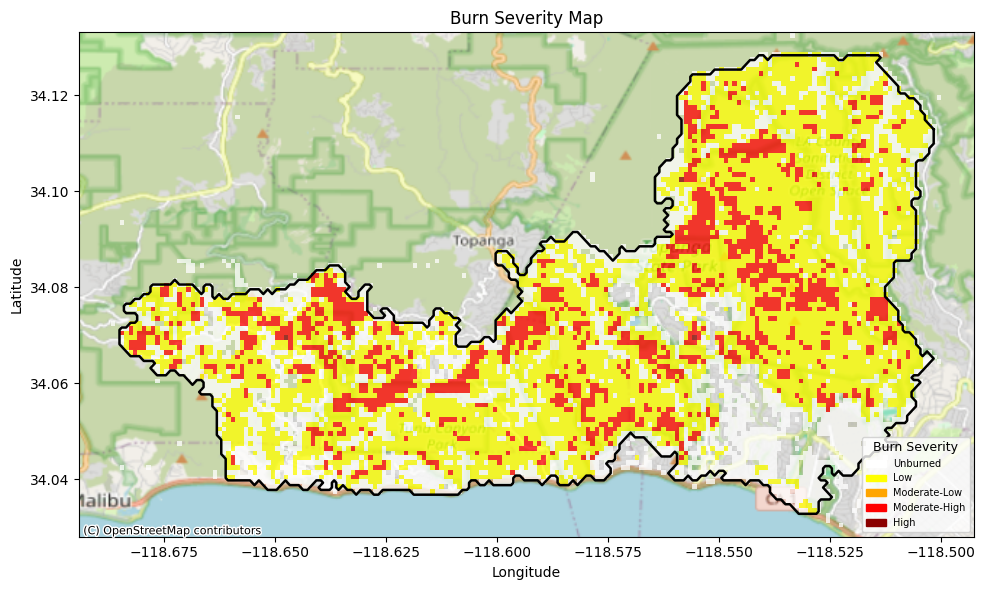

In [58]:
roi_1 = ee.Geometry.Rectangle([-118.7, 34.0, -118.4, 34.20]) 

dnbr_roi_1 = dnbr.clip(roi_1)
severity_roi_1 = classify_dnbr(dnbr_roi_1)
ds_severity_roi_1 = geemap.ee_to_xarray(severity_roi_1, geometry=roi_1, crs='EPSG:4326', scale=0.001)
da = ds_severity_roi_1.to_array().squeeze()

da_burned = da.where(da > 0) # Mask out zero or unburned pixels

extent = [
    float(da_burned.coords['lon'].min()), float(da_burned.coords['lon'].max()),
    float(da_burned.coords['lat'].min()), float(da_burned.coords['lat'].max())
]

binary = da_burned.values > 0
binary = morphology.remove_small_objects(binary, min_size=100)
binary = morphology.remove_small_holes(binary, area_threshold=100)
contours = measure.find_contours(binary, level=0.5)


severity_colors = mcolors.ListedColormap(['white', 'yellow', 'orange', 'red', 'darkred'])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, severity_colors.N)

fig, ax = plt.subplots(figsize=(10, 6))

# im = ax.pcolormesh(da_burned.coords['lon'], da_burned.coords['lat'], da_burned.T, cmap='Reds')


for contour in contours:
    # Convert pixel coords to geographic (lon/lat)
    row, col = contour[:, 1],contour[:, 0]
    lat = np.interp(row, [0, binary.shape[1]], [extent[2], extent[3]])
    lon = np.interp(col, [0, binary.shape[0]], [extent[0], extent[1]])
    ax.plot(lon, lat, color='black', linewidth=1.8)

da.rio.write_crs("EPSG:4326", inplace=True)
cx.add_basemap(ax, crs=da.rio.crs, source=cx.providers.OpenStreetMap.Mapnik)
# im = ax.imshow(da_burned, extent=extent, origin='lower', cmap='Reds', alpha=0.8)
im = ax.pcolormesh(da_burned.coords['lon'], da_burned.coords['lat'], da_burned.T, cmap= severity_colors, alpha=0.75)

labels = ['Unburned', 'Low', 'Moderate-Low', 'Moderate-High', 'High']
handles = [Patch(color=severity_colors(i), label=labels[i]) for i in range(len(labels))]
ax.legend(handles=handles, title="Burn Severity", loc='lower right', fontsize=7, title_fontsize=9)

# cbar = fig.colorbar(im, ax=ax, label='Fire Severity Class', fraction=0.035, pad=0.01, aspect=18)
ax.set_title('Burn Severity Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

In [54]:
burned_values = da_burned.values.flatten()
burned_values = burned_values[~np.isnan(burned_values)]

unique, counts = np.unique(burned_values, return_counts=True)

total_burned = counts.sum() # Total burned pixels
burned_percentages = {int(k): (v / total_burned) * 100 for k, v in zip(unique, counts)}

labels = {
    1: 'Low',
    2: 'Moderate-low',
    3: 'Moderate-high',
    4: 'High'
}

for severity, pct in burned_percentages.items():
    label = labels.get(severity, f"Class {severity}")
    print(f"{label} ({severity}): {pct:.2f}%")


Low (1): 30.31%
Moderate-low (2): 52.87%
Moderate-high (3): 16.79%
High (4): 0.03%
